**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**October, 2023**

---

# Run limma differential expression analysis

In [1]:
library(limma)
library(scuttle)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(Seurat)
library(edgeR)
library(reshape2)
library(magrittr)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [2]:
anndata <- readRDS('../../data_integration_v2/results/scVI/malaria_singleNuclei_24h.rds')
anndata

An object of class Seurat 
36601 features across 9059 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [3]:
Idents(anndata)= anndata$donor_id

In [4]:
anndata= subset(x = anndata, idents = c("snDonor_Pf0", "snDonor_Pf1", "snDonor_Pf2", "snDonor_Pf3"))

In [5]:
levels(x = anndata) <- c("snDonor_Pf0", "snDonor_Pf1", "snDonor_Pf2", "snDonor_Pf3")

In [6]:
anndata$donor_id <- factor(anndata$donor_id, levels = c("snDonor_Pf0", "snDonor_Pf1", "snDonor_Pf2", "snDonor_Pf3"))

In [8]:
Idents(anndata)= anndata$cell_type

In [9]:
head(Idents(anndata))

Pla_HDBR11923126_AAACCCATCGTCTACC Pla_HDBR11923126_AAACGAATCGCAACAT 
                              SCT                               SCT 
Pla_HDBR11923126_AAACGCTTCGGCACTG Pla_HDBR11923126_AAAGAACAGCAGTACG 
                              SCT                              iEVT 
Pla_HDBR11923126_AAAGAACGTCCATAGT Pla_HDBR11923126_AAAGAACGTGTTAAAG 
                              SCT                             VCT_p 
Levels: EVT_1 EVT_2 SCT VCT VCT_CCC VCT_fusing VCT_p iEVT

# Trophoblast

In [10]:
Troph= subset(x = anndata, idents = c("SCT","VCT_fusing","VCT"))

Idents(object = Troph) <- "infection"



#Troph$celltype.Stage<- Troph$Identity.Stage


#fixxing levels
Troph$celltype.Stage = factor(Troph$celltype.Stage, levels = c("SCT-Pf_24h","SCT-UI_Pf_24h","VCT_fusing-Pf_24h", "VCT_fusing-UI_Pf_24h", "VCT-Pf_24h","VCT-UI_Pf_24h"))
Troph$cell_type<- factor(Troph$cell_type, levels = c("SCT","VCT_fusing", "VCT"))

#The levels for the infection should follow this order to ensure that positive Fold changes correspond to increases in infection
Troph$infection<- factor(Troph$infection, levels = c("UI","Pf"))

In [11]:
Troph$classification = paste(Troph$cell_type, Troph$infection, sep='-') # split celltype by disease status


# estimate % cells expressing a gene in each class
plot <- DotPlot(object = Troph, features = rownames(Troph), group.by = 'classification')
plot$data$value = plot$data$pct.exp
percent_mat = acast(plot$data, features.plot ~ id)

In [12]:
head(percent_mat)

,SCT-Pf,SCT-UI,VCT_fusing-Pf,VCT_fusing-UI,VCT-Pf,VCT-UI
MIR1302-2HG,0.000000,0.07800312,0.000000,0.000000,0.0000000,0.000000
FAM138A,0.000000,0.00000000,0.000000,0.000000,0.0000000,0.000000
OR4F5,0.000000,0.00000000,0.000000,0.000000,0.0000000,0.000000
AL627309.1,3.686636,2.02808112,4.863222,3.448276,2.9761905,3.112033
AL627309.3,0.000000,0.00000000,0.000000,0.000000,0.0000000,0.000000
AL627309.2,0.000000,0.07800312,0.000000,0.000000,0.1984127,0.000000


In [13]:
percent_mat[c('PGF','FLT1'),]

,SCT-Pf,SCT-UI,VCT_fusing-Pf,VCT_fusing-UI,VCT-Pf,VCT-UI
PGF,71.65899,80.10920,79.93921,86.89655,79.36508,80.91286
FLT1,89.05530,83.46334,89.96960,77.58621,95.03968,87.86307


In [14]:
head(percent_mat)

,SCT-Pf,SCT-UI,VCT_fusing-Pf,VCT_fusing-UI,VCT-Pf,VCT-UI
MIR1302-2HG,0.000000,0.07800312,0.000000,0.000000,0.0000000,0.000000
FAM138A,0.000000,0.00000000,0.000000,0.000000,0.0000000,0.000000
OR4F5,0.000000,0.00000000,0.000000,0.000000,0.0000000,0.000000
AL627309.1,3.686636,2.02808112,4.863222,3.448276,2.9761905,3.112033
AL627309.3,0.000000,0.00000000,0.000000,0.000000,0.0000000,0.000000
AL627309.2,0.000000,0.07800312,0.000000,0.000000,0.1984127,0.000000


In [15]:
#print(Idents(VCT_fusing))

In [16]:
table(Troph[["celltype.Stage"]] )


          SCT-Pf_24h        SCT-UI_Pf_24h    VCT_fusing-Pf_24h 
                1736                 1282                  329 
VCT_fusing-UI_Pf_24h           VCT-Pf_24h        VCT-UI_Pf_24h 
                 290                  504                  964 

In [17]:
anndata_sce <- as.SingleCellExperiment(Troph)

In [18]:
anndata_sce

class: SingleCellExperiment 
dim: 36601 5105 
metadata(0):
assays(2): counts logcounts
rownames(36601): MIR1302-2HG FAM138A ... AC007325.4 AC007325.2
rowData names(0):
colnames(5105): Pla_HDBR11923126_AAACCCATCGTCTACC
  Pla_HDBR11923126_AAACGAATCGCAACAT ...
  Pla_HDBR13026231_TTTGGTTTCTGCTGAA Pla_HDBR13026231_TTTGTTGAGGCTTAAA
colData names(17): donor infection ... classification ident
reducedDimNames(0):
altExpNames(0):

### Prepare the pseudobulk count matrix:

In [40]:
# generate 3 metacells for each donor-celltype combination
n=5
anndata_sce$random_seed = sample(1:n, size = ncol(anndata_sce), replace = T)
anndata_sce$metacell_id = paste( colData(anndata_sce)$infection, 
                                colData(anndata_sce)$cell_type, 
                                colData(anndata_sce)$donor_id, 
                                colData(anndata_sce)$random_seed, 
                                sep='-')
## aggregateAcrossCells here it is only aggregated by celltype, genotype and random group
summed <- aggregateAcrossCells(anndata_sce, id=colData(anndata_sce)[,c("metacell_id")])

##have a look at the counts
counts(summed)[1:3,]


#have a look at the colData of our new object summed, can you see Group and 
# metacell_id are there
# colData(summed)
table(summed$classification)
table(summed$infection)

,Pf-SCT-snDonor_Pf0-1,Pf-SCT-snDonor_Pf0-2,Pf-SCT-snDonor_Pf0-3,Pf-SCT-snDonor_Pf0-4,Pf-SCT-snDonor_Pf0-5,Pf-SCT-snDonor_Pf1-1,Pf-SCT-snDonor_Pf1-2,Pf-SCT-snDonor_Pf1-3,Pf-SCT-snDonor_Pf1-4,Pf-SCT-snDonor_Pf1-5,⋯,UI-VCT-snDonor_Pf2-1,UI-VCT-snDonor_Pf2-2,UI-VCT-snDonor_Pf2-3,UI-VCT-snDonor_Pf2-4,UI-VCT-snDonor_Pf2-5,UI-VCT-snDonor_Pf3-1,UI-VCT-snDonor_Pf3-2,UI-VCT-snDonor_Pf3-3,UI-VCT-snDonor_Pf3-4,UI-VCT-snDonor_Pf3-5
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0



       SCT-Pf        SCT-UI VCT_fusing-Pf VCT_fusing-UI        VCT-Pf 
           20            20            20            20            20 
       VCT-UI 
           19 


UI Pf 
59 60 

In [41]:
summed

class: SingleCellExperiment 
dim: 36601 119 
metadata(0):
assays(1): counts
rownames(36601): MIR1302-2HG FAM138A ... AC007325.4 AC007325.2
rowData names(0):
colnames(119): Pf-SCT-snDonor_Pf0-1 Pf-SCT-snDonor_Pf0-2 ...
  UI-VCT-snDonor_Pf3-4 UI-VCT-snDonor_Pf3-5
colData names(21): donor infection ... ids ncells
reducedDimNames(0):
altExpNames(0):

In [42]:
summed$infection<- factor(summed$infection, levels = c( "UI","Pf"))

In [43]:
table(summed$infection)


UI Pf 
59 60 

### Corrected by genotype

In [44]:
DEGs_list = list()

In [45]:
for (celltypeOf_interest in unique(summed$cell_type) ){
    
    #celltypeOf_interest = 'VCT'
    print(celltypeOf_interest)

    # (0) Subset to celltype
    summed_celltype = subset(summed, , summed$cell_type == celltypeOf_interest)


    # (1) Generate a DGEList object to use as input for limma and filter the genes to remove lowly expressed genes. How many are left?
    #As in the standard limma analysis generate a DGE object
    y <- DGEList(counts(summed_celltype), samples=colData(summed_celltype)$metacell_id)

    ##filter lowly expressed (recommended for limma)
    #     keep <- filterByExpr(y, group=summed_celltype$dataset, min.total.count = 3000, min.prop = 0.1)
    keep <- filterByExpr(y, group=summed_celltype$donor_id, min.prop = 0.2)

    genes20percent = rownames(percent_mat)[ apply(percent_mat[, unique(summed_celltype$classification) ], 1, max) > 10 ] # get genes with > 20% expressed cells in the celltypeOf_interest
    keep <- keep & names(keep) %in% genes20percent
    y <- y[ keep ,]



    # (2) Perform TMM normalization using edgeR, and then limma can perform the transformation with voom, fit the model, compute the contrasts and compute test statistics with eBayes:
    y <- edgeR::calcNormFactors(y)


    ##see how many genes were kept 
    summary(keep)


    # (3) Generate a design matrix, including dataset to model for a paired analysis. 
    # If you need help to generate a design matrix, check out the very nice edgeR User Guide, sections 3.3 and 3.4. 
    ## Create the design matrix for paired samples while correcting for the effect of the donor to obtain
    #  the overall effect of the infection across donors:
    design <- model.matrix(~summed_celltype$donor_id+summed_celltype$infection)
        # stimate dispersion
    y <- estimateDisp(y,design)
        # Have a look
    head(design)


    # (4) Do limma DEG
    fit <- glmQLFit(y, design)
    qlf <- glmQLFTest(fit)
    topTags(qlf)

    ##  Adjust P values using bonferroni and BH
    limma_de = qlf$table
    limma_de$bonferroni = p.adjust(limma_de$PValue, "bonferroni")
    limma_de$p_val_adj = p.adjust(limma_de$PValue, "BH")
        
    # order table by P-value
    limma_de= limma_de[ order(limma_de$p_val_adj, decreasing = FALSE), ]
    #limma_de <- order(limma_de$p.adjust, decreasing = FALSE)
    #imma_de = limma_de.sort_values('p.adjust', ascending = TRUE)

    # Adding to the list
    DEGs_list[[celltypeOf_interest]] = limma_de
} 

[1] "SCT"
[1] "VCT_fusing"
[1] "VCT"


In [46]:
##  Saving the DEG matrix
write.table(DEGs_list[["SCT"]],'../results/SN_limma_Trophoblast_MAL_24h/1_DEGs_SN_MAL_24h_SCT.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)
write.table(DEGs_list[["VCT_fusing"]],'../results/SN_limma_Trophoblast_MAL_24h/2_DEGs_SN_MAL_24h_VCT_fusing.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)
write.table(DEGs_list[["VCT"]],'../results/SN_limma_Trophoblast_MAL_24h/3_DEGs_SN_MAL_24h_VCT.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)


In [19]:
#colData(summed_celltype)$metacell_id

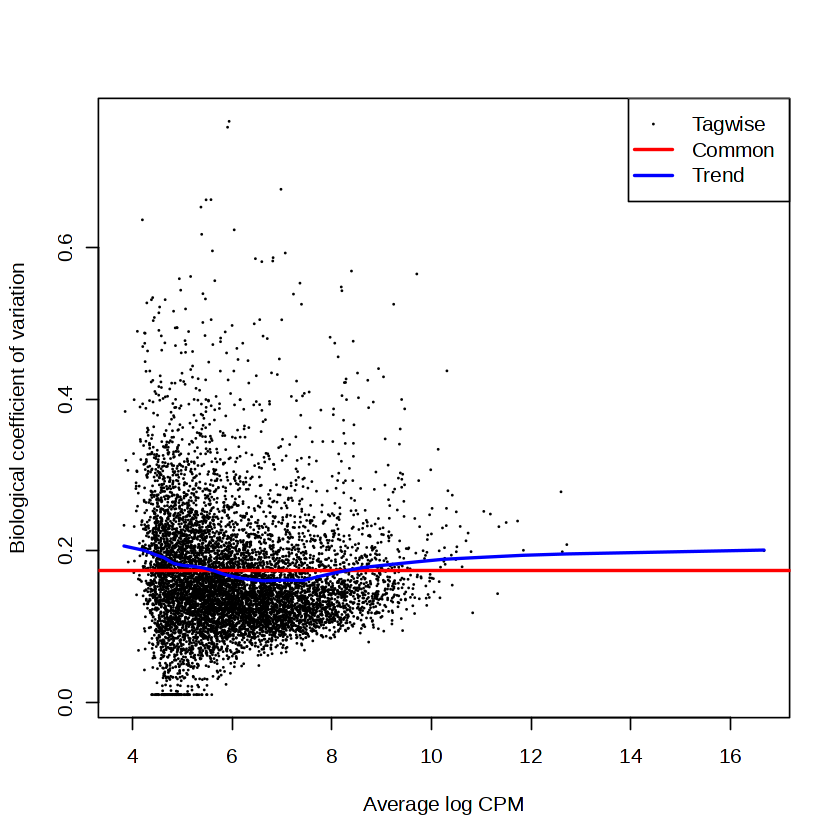

In [47]:
plotBCV(y)

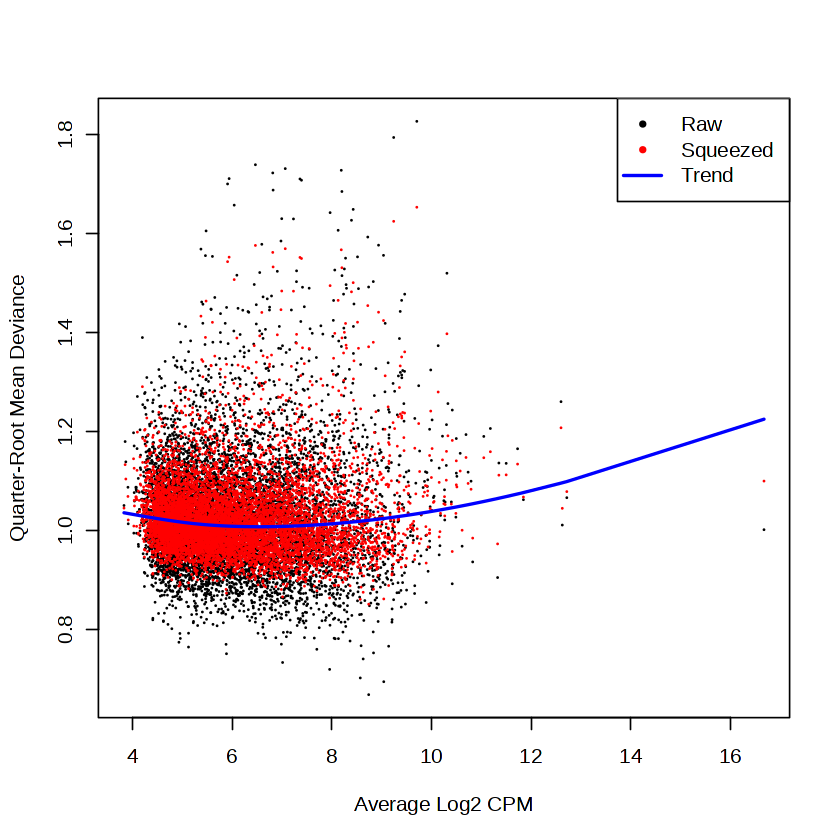

In [48]:
plotQLDisp(fit)

In [49]:
o <- order(qlf$table$PValue)
cpm(y)[o[1:20],]

,Pf-VCT-snDonor_Pf0-1,Pf-VCT-snDonor_Pf0-2,Pf-VCT-snDonor_Pf0-3,Pf-VCT-snDonor_Pf0-4,Pf-VCT-snDonor_Pf0-5,Pf-VCT-snDonor_Pf1-1,Pf-VCT-snDonor_Pf1-2,Pf-VCT-snDonor_Pf1-3,Pf-VCT-snDonor_Pf1-4,Pf-VCT-snDonor_Pf1-5,⋯,UI-VCT-snDonor_Pf2-1,UI-VCT-snDonor_Pf2-2,UI-VCT-snDonor_Pf2-3,UI-VCT-snDonor_Pf2-4,UI-VCT-snDonor_Pf2-5,UI-VCT-snDonor_Pf3-1,UI-VCT-snDonor_Pf3-2,UI-VCT-snDonor_Pf3-3,UI-VCT-snDonor_Pf3-4,UI-VCT-snDonor_Pf3-5
LGALS16,26.57199,48.241036,39.264022,30.235115,33.333042,59.50812,59.3530,41.31950,43.41094,9.622155,⋯,23.787628,50.212408,32.017467,31.875731,58.544605,52.91012,32.897007,27.306679,31.822187,25.587310
OBI1-AS1,780.80769,883.078967,842.666317,846.583206,866.659082,107.11462,83.0942,72.30913,10.85274,96.221549,⋯,604.885392,228.238218,708.958196,327.864657,476.340198,2157.55726,1233.637764,1339.977763,1492.293082,1127.440838
CGB3,42.92398,62.981353,36.243713,46.148333,53.332867,130.91787,71.2236,51.64938,21.70547,96.221549,⋯,20.389395,13.694293,13.721772,9.107352,15.966711,19.59634,29.241784,33.158111,25.122779,30.384930
HSD17B1,547.79178,558.792002,480.229191,474.213901,555.550693,797.40887,842.8126,929.68877,672.86962,827.505322,⋯,312.637394,351.486856,306.452898,236.791141,314.011974,197.92305,159.002201,148.236259,167.485194,132.734170
ELF5,14.30799,8.040173,9.060928,27.052471,11.111014,0.00000,0.0000,15.49481,0.00000,0.000000,⋯,6.796465,2.282382,13.721772,0.000000,2.661118,109.73952,51.173122,60.464790,46.895854,65.567481
SLC7A8,14.30799,13.400288,27.182784,12.730575,26.666433,23.80325,0.0000,20.65975,43.41094,9.622155,⋯,118.938139,73.036230,73.182782,86.519840,66.527961,195.96342,193.726819,161.889599,123.939044,159.920686
APOLD1,102.19996,30.820662,75.507734,82.748734,82.221503,0.00000,35.6118,72.30913,0.00000,28.866465,⋯,91.752279,59.341937,100.626325,104.734543,87.816908,429.15989,292.417840,331.581106,247.878088,243.079443
EDNRB,206.44392,274.705900,228.033358,249.837525,251.108913,47.60650,11.8706,20.65975,0.00000,19.244310,⋯,125.734604,34.235733,109.774172,31.875731,90.478026,875.95649,444.109595,440.807823,606.296404,388.607268
LGALS13,12.26400,14.740317,15.101547,17.504540,8.888811,47.60650,23.7412,25.82469,65.11641,9.622155,⋯,0.000000,6.847147,4.573924,13.661027,18.627829,11.75781,5.482835,5.851431,6.699408,7.996034
HSPA1A,49.05598,28.140604,37.753867,41.374367,35.555244,35.70487,47.4824,46.48444,0.00000,28.866465,⋯,13.592930,22.823822,18.295695,4.553676,5.322237,11.75781,14.620892,7.801908,15.073667,14.392862


In [50]:
summary(decideTests(qlf))

       summed_celltype$infectionPf
Down                           951
NotSig                        6122
Up                            1040

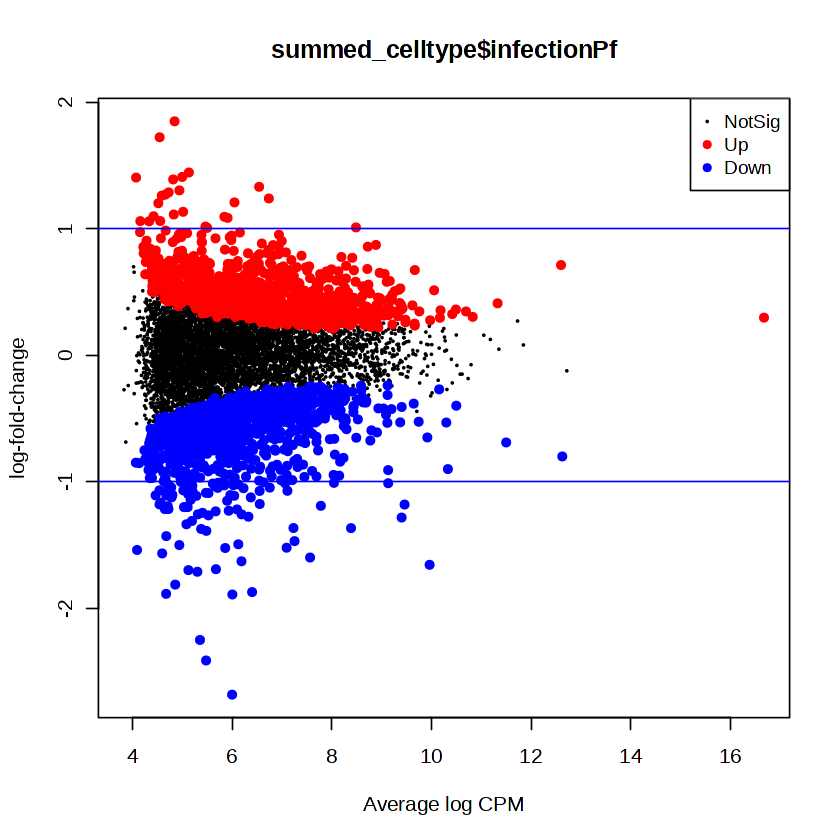

In [51]:
plotMD(qlf)
abline(h=c(-1, 1), col="blue")

In [52]:
limma_de = qlf$table
limma_de$p.adjust = p.adjust(limma_de$PValue, "bonferroni")
limma_de$BH = p.adjust(limma_de$PValue, "BH")

hist(tt$PValue)

ERROR: Error in hist(tt$PValue): object 'tt' not found


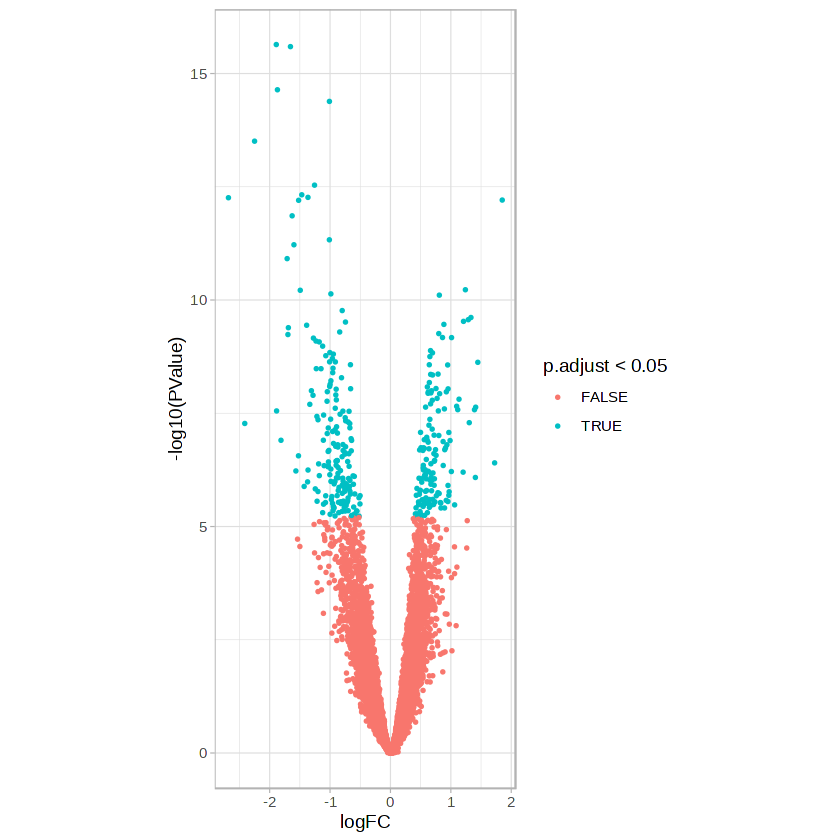

In [53]:
library(ggplot2, warn.conflicts = FALSE)
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = p.adjust < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

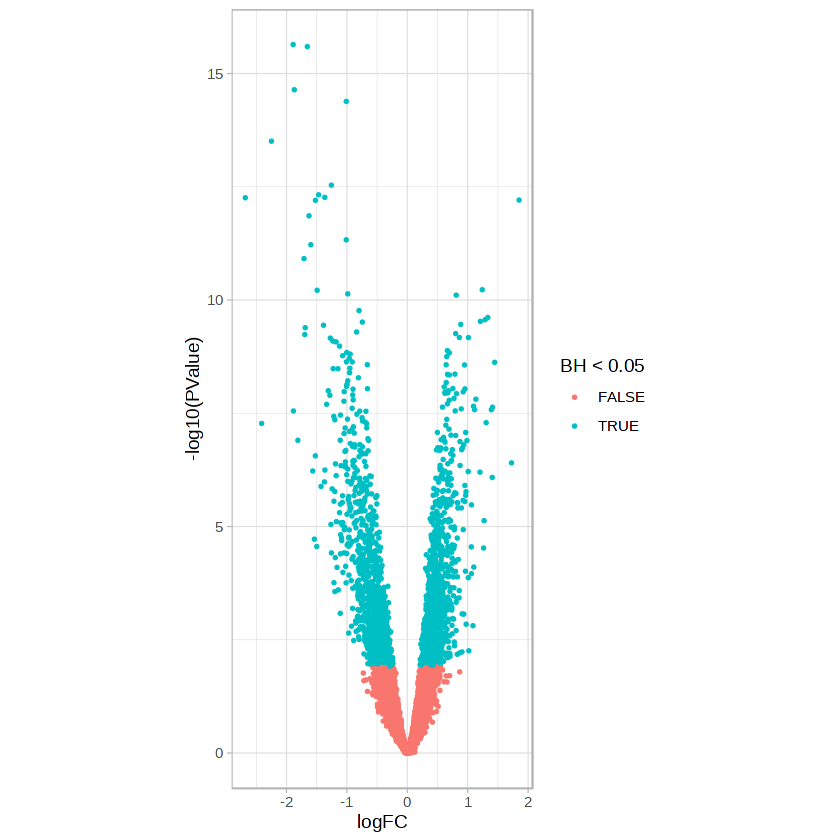

In [54]:
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = BH < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

In [2]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] magrittr_2.0.3              reshape2_1.4.4             
 [3] edgeR_3.32.1                SeuratObject_4.0.0         
 [5] Seurat_4.0.1                patchwork_1.1.1            
 [7] dplyr_1.0.5                 scran_1.18.5               
